# Composition Axon Projection

This example allows the user to place an extra axonal arborisation to represent long range projections to other structures.

## Define volumes
Here we use ```create_cube_mesh``` to create two cubical volumes with sides 300 micrometer that are 10 mm apart.

In [1]:
import os
from snudda.place import create_cube_mesh

network_path = os.path.join("networks", "composite_axon_example")
mesh_file_a = os.path.join(network_path, "mesh", "volume_A.obj")
mesh_file_b = os.path.join(network_path, "mesh", "volume_B.obj")

create_cube_mesh(mesh_file_a, [5e-3,0,0], 300e-6, "Volume A - connect structures example")
create_cube_mesh(mesh_file_b, [-5e-3,0,0], 300e-6, "Volume B - connect structures example")

rc = None

duration = 1.0

## Defining network, including projection

Normally neurons are connected using touch detection, but here we show how to connect neurons in separate volumes together. This can be used to create topographic maps between structures. To define a projection map (here data/ExampleProjectionDetection.json) we define a set of source points, and their corresponding target points. Intermediate points will be interpolated. Note that points outside the convex hull of the source points will have no projection defined.

```
{
    "ExampleProjection" : {
    "source" : [[4850, -150, -150],
                    [4850, -150, 150],
                    [4850, 150, -150],
                    [4850, 150, 150],
                    [5150, -150, -150],
                    [5150, -150, 150],
                    [5150, 150, -150],
                    [5150, 150, 150]],
    
    "destination" : [[-5150, -150, -150],
                         [-5150, -150, 150],
                         [-5150, 150, -150],
                         [-5150, 150, 150],
                         [-4850, -150, -150],
                         [-4850, -150, 150],
                         [-4850, 150, -150],
                         [-4850, 150, 150]],

     "axonMorphology" : ["$SNUDDA_DATA/InputAxons/GPe2Striatum/prototypical-axon.swc"],
     "rotation" : [[1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 0, 0, 1, 0, 0, 0, 1]]
    }

}

```
Here a neuron at ```[4850, -150, -150]``` will project to a neuron at ```[-5150, -150, -150]```.

The projection extent is defined by the axonMorphology, if more than one morphology is given in the list, then a random morphology is picked for each projection. The morphology is placed at the location of the projection, with the rotation given by the optional rotation matrix (9x1 corresponding to the 3x3 rotation matrix) for each destination point).

We define the structures (define_structure) using the mesh files created above, and add the neurons to the two volumes (add_neurons).

We use add_neuron_target but add also the projection_file as argument.

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="VolumeA", struct_mesh=mesh_file_a, d_min=15e-6, mesh_bin_width=50e-6)
si.define_structure(struct_name="VolumeB", struct_mesh=mesh_file_b, d_min=15e-6, mesh_bin_width=50e-6)

proj_file = os.path.join("$SNUDDA_DATA", "InputAxons", "GPe2Striatum", "example-projection-config.json")

si.add_neurons(name="dSPN", num_neurons=20, volume_id="VolumeA",
               neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"),
               axon_config=proj_file)
si.add_neurons(name="iSPN", num_neurons=20, volume_id="VolumeB",
               neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

# Normally we would use add_neuron_target to connect the neurons in the same volume together, 
# but this time we want to use neuron_projection instead.

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
pfdSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")

si.add_neuron_target(neuron_name="dSPN",
                     target_name="iSPN",
                     connection_type="GABA",
                     # projection_file=proj_file, # -- moved to add_neuron
                     projection_name="ExampleProjection",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None, a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     parameter_file=pfdSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": 0.7})

si.write_json()

Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/composite_axon_example/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5


In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 1166/11160 (36 neurons)
Processing hyper voxel : 886/11160 (32 neurons)
Processing hyper voxel : 887/11160 (31 neurons)
Processing hyper voxel : 1157/11160 (31 neurons)
Processing hyper voxel : 877/11160 (30 neurons)
Processing hyper voxel : 878/11160 (29 neurons)
Processing hyper voxel : 1165/11160 (29 neurons)
Processing hyper voxel : 1156/11160 (24 neurons)
Processing hyper voxel : 885/11160 (22 neurons)
Processing hyper voxel : 879/11160 (21 neurons)
Processing hyper voxel : 1964/11160 (20 neurons)
Processing hyper voxel : 1335/11160 (20 neurons)
Processing hyper voxel : 870/11160 (20 neurons)
Processing hyper voxel : 2001/11160 (20 neurons)
Processing hyper voxel : 757/11160 (20 neurons)
Processin

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

Read 61 out of total 61 synapses


In [6]:
from snudda.input import SnuddaInput

si = SnuddaInput(network_path=network_path, rc=rc, input_config_file="test-input.json")
si.generate()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
Loading 40 neurons with 22 synapses and 0 gap junctions
Writing spikes to networks/composite_axon_example/input-spikes.hdf5


Loading 40 neurons with 22 synapses and 0 gap junctions
Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5


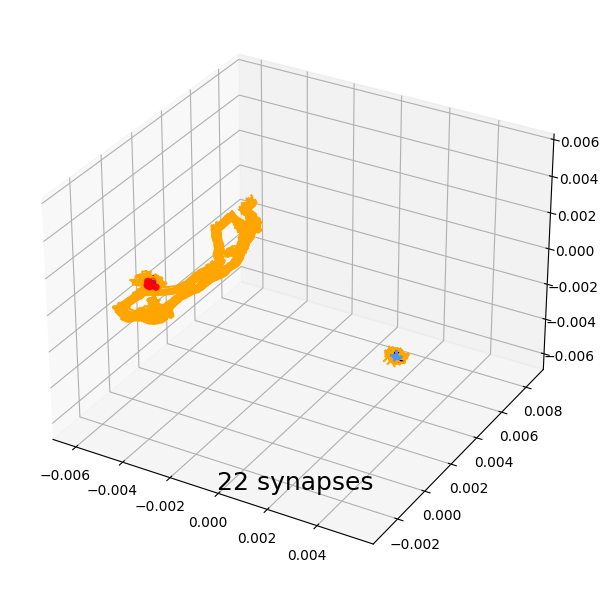

(<module 'matplotlib.pyplot' from '/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <Axes3DSubplot:>)

In [7]:
from snudda.plotting import PlotNetwork
pn = PlotNetwork(network=network_path)
pn.plot()

In [8]:
from snudda.simulate import SnuddaSimulate
from snudda.core import Snudda

sim = SnuddaSimulate(network_path=network_path)
Snudda.compile_mechanisms()
sim.setup()
sim.add_external_input()
sim.add_volt_recording_soma()
sim.run(t=duration*1e3)
sim.write_output()

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
Loading 40 neurons with 22 synapses and 0 gap junctions
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20190603/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20190603/modulation.json
Warning! No modulation key specified, ignoring /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20190611/modulation.json
Warning! No modulation key specified, ignoring /home/

Loading 40 neurons with 22 synapses and 0 gap junctions
Loading networks/composite_axon_example/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
6: (iSPN_3, default, )
10: (iSPN_3, default, )
14: (iSPN_3, default, )
17: (iSPN_3, default, )
18: (iSPN_3, default, )
22: (dSPN_2, default, )
23: (dSPN_2, default, )
24: (dSPN_2, default, )
29: (dSPN_2, default, )
36: (dSPN_2, default, )
Saving figure to networks/composite_axon_example/figures/spike-raster.png


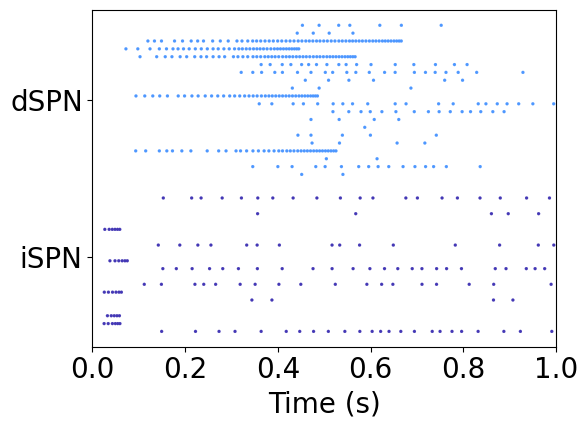

In [9]:
from snudda.plotting import SnuddaPlotSpikeRaster2
fig_file_raster = f"spike-raster.png"

time_range_zoom = (0,duration)
spr = SnuddaPlotSpikeRaster2(network_path=network_path)


spr.plot_spike_raster(fig_file=fig_file_raster, time_range=time_range_zoom)